# Overview: 

This notebook is created to do tasks given in issue no #4: [Traversal of the space of cross-validation folds](https://github.com/mozilla/PRESC/issues/4)


## Task

Write a function that 
- takes a scikit-learn estimator and a dataset
- computes an evaluation metric using **repeated K-fold cross-validation** over a grid of K values from 1 to n. 
- It should output a **table of K** with the average metric value across the folds, one for each repeat.


--- 

Here I will avoide other cell discription except which are related to cross-validation and focus on it. I discribed those earlier. 


--- 

In [29]:
# Import basic libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# import visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
from ggplot import *
%matplotlib inline
#import itertools

#importing libraries for Decision tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.metrics import (brier_score_loss, precision_score, recall_score, roc_auc_score)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score

In [19]:
df = pd.read_csv("../../datasets/defaults.csv")

In [20]:
df = df.rename(columns={'defaulted': 'def_pay','pay_0': 'pay_1'})
#df.head()

In [21]:
# creating the target variable
y = df['def_pay'].copy()
#y.sample(5)

In [22]:
# creating the features, which now will be everything in the original df
features = ['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_1', 'pay_2',
       'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']
X = df[features].copy()
X.columns

Index(['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_1', 'pay_2',
       'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6'],
      dtype='object')

In [23]:
# split the df into train and test, it is important these two do not communicate during the training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [24]:
#createing the classifier
classifier = DecisionTreeClassifier(max_depth=100, random_state=14) 
# training the classifier
classifier.fit(X_train, y_train)
# doing predictions on the test
predictions = classifier.predict(X_test)


# seeing how good we did on the test
accuracy_score(y_true = y_test, y_pred = predictions)

0.812

**Accuracy: 81%**
Now trying overfitting by increasing the maximum depth of the tree.

In [26]:
# define the parameters grid
param_grid = {'max_depth': np.arange(3, 10),
             'criterion' : ['gini','entropy'],
             'max_leaf_nodes': [5,10,20,100],
             'min_samples_split': [2, 5, 10, 20]}

# create the grid
grid_tree = GridSearchCV(DecisionTreeClassifier(), param_grid, cv = 5, scoring= 'accuracy')
# the cv option will be clear in a few cells

#training
grid_tree.fit(X_train, y_train)
#let's see the best estimator
print(grid_tree.best_estimator_)
#with its score
print(np.abs(grid_tree.best_score_))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=20,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
0.8212916666666666


In [27]:
classifier = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=20,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)
accuracy_score(y_true = y_test, y_pred = predictions)

0.821

The accuracy got increased **0.07%** just by choosing the right parameters..

To cross validate, I will do another thing. I will use **Kfold**. 




   
 # Cross-validation


Cross-validation is used for parameter tuning, model selection, and feature selection. K-fold cross-validation is a systematic process for repeating the train/test split procedure multiple times, in order to reduce the variance associated with a single trial of train/test split.


### Steps for K-fold cross-validation

1. Split the dataset into K equal partitions (or "folds").
2. Use fold 1 as the testing set and the union of the other folds as the training set.
3. Calculate testing accuracy.
4. Repeat steps 2 and 3 K times, using a different fold as the testing set each time.
5. Use the average testing accuracy as the estimate of out-of-sample accuracy.


## Comparing cross-validation to train/test split

**Advantages of cross-validation:**

- More accurate estimate of out-of-sample accuracy
- More "efficient" use of data (every observation is used for both training and testing)

**Advantages of train/test split:**

- Runs K times faster than K-fold cross-validation
- Simpler to examine the detailed results of the testing process



**Cross-validation recommendations**

- K can be any number, but K=10 is generally recommended
- For classification problems, stratified sampling is recommended for creating the folds
    - Each response class should be represented with equal proportions in each of the K folds
    - scikit-learn's cross_val_score function does this by default




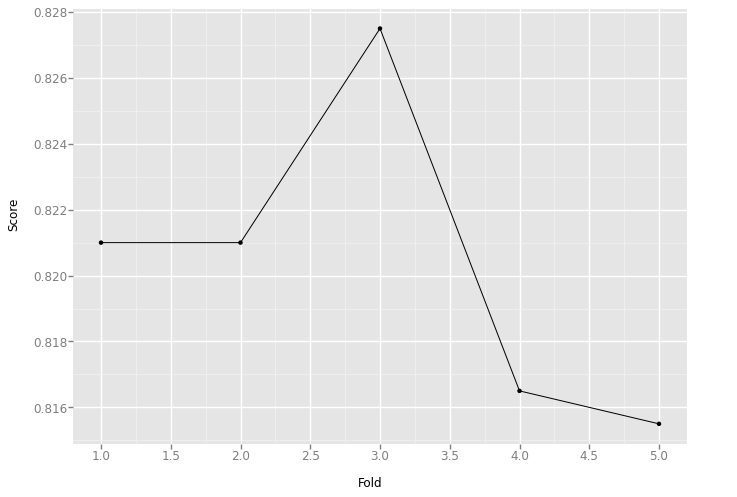

<ggplot: (-9223371875516667143)>


In [30]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)

fold = []
scr = []

for i,(train_index, test_index) in enumerate(kf.split(df)):
    training = df.iloc[train_index,:]
    valid = df.iloc[test_index,:]
    feats = training[features] #defined above
    label = training['def_pay']
    valid_feats = valid[features]
    valid_label = valid['def_pay']
    classifier.fit(feats,label) #it is the last one we run, the best one
    pred = classifier.predict(valid_feats)
    score = accuracy_score(y_true = valid_label, y_pred = pred)
    fold.append(i+1)
    scr.append(score)
    
#create a small df with the scores
performance = pd.DataFrame({'Score':scr,'Fold':fold})
# let's see what we have with ggplot
g = ggplot(performance,aes(x='Fold',y='Score')) + geom_point() + geom_line()
print(g)

Now, this does not mean much now, since it is only one model and, depending on how we split the df into train and test, we get a precision between 0.816 and 0.8275, which may or may not be relevant depending on the purpose of the model. 


## Improvements to cross-validation

if we used these following steps, we could have improvements to cross-validation

**Repeated cross-validation**

- Repeat cross-validation multiple times (with different random splits of the data) and average the results
- More reliable estimate of out-of-sample performance by reducing the variance associated with a single trial of cross-validation

**Creating a hold-out set**

- "Hold out" a portion of the data before beginning the model building process
- Locate the best model using cross-validation on the remaining data, and test it using the hold-out set
- More reliable estimate of out-of-sample performance since hold-out set is truly out-of-sample

**Feature engineering and selection within cross-validation iterations**

- Normally, feature engineering and selection occurs before cross-validation
- Instead, perform all feature engineering and selection within each cross-validation iteration
- More reliable estimate of out-of-sample performance since it better mimics the application of the model to out-of-sample data
